In [1]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
import matplotlib.pyplot as plt
from scipy import signal
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

from losses import *

Input: 
	 torch.Size([1, 1, 28, 28]) 0.0 1.0


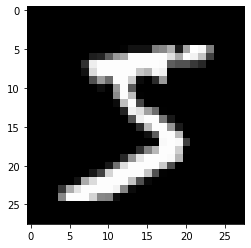

Target: 
	 torch.Size([1, 1, 28, 28]) 0.0 1.0


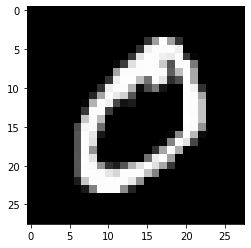

In [2]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
ds = MNIST("../notebooks/mnist_example/", download=False, train=True, transform=train_transform)


# train_transform = Compose([
#     Resize(28),
#     ToTensor(),
#     Grayscale(),
# ])
# ds = CIFAR10("../notebooks/cifar10_example/", download=False, train=True, transform=train_transform)

# Input example
input = ds[0][0].unsqueeze(0)
print("Input: \n\t", input.shape, input.min().item(), input.max().item())
plt.imshow(input.squeeze(0).squeeze(0), cmap="gray")
plt.show()

# Target example
target = ds[1][0].unsqueeze(0)
print("Target: \n\t", target.shape, target.min().item(), target.max().item())
plt.imshow(target.squeeze(0).squeeze(0), cmap="gray")
plt.show()

# Dimensions
h, w = input.shape[2], input.shape[3]


Filter size:  1567


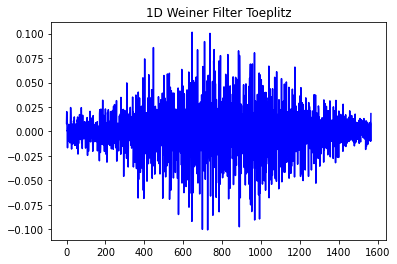

(28, 28)


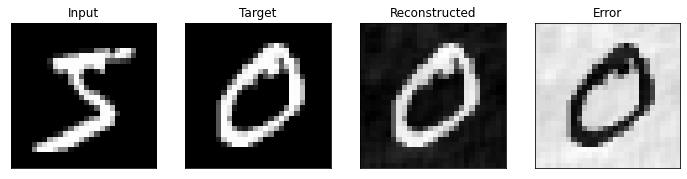

In [3]:
# 1D Weiner Filter using Toeplitz
aw1d = AWLoss1D(epsilon=0., store_filters=True)
_ = aw1d(target, input)
vfilter = aw1d.v_all[0]
print("Filter size: ", len(vfilter))
plt.plot(vfilter, color="blue")
plt.title("1D Weiner Filter Toeplitz")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), vfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)

# Error
print(recon.shape)
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

Filter size:  1567


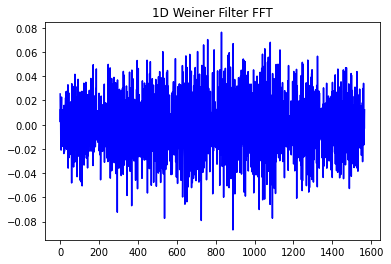

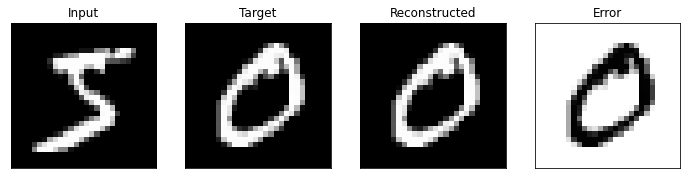

In [4]:
# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=0., store_filters=True)
_ = aw1dfft(input, target)
wfilter = aw1dfft.v_all[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner Filter FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
# recon = signal.convolve(torch.flip(input, dims=(0,1)).flatten(start_dim=0), wfilter, mode="full")
recon = signal.convolve(input.flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)
# print(recon.shape)
# plt.plot(target.flatten(start_dim=0), label="target")
# plt.plot(input.flatten(start_dim=0), label="input")
# plt.plot(recon.flatten(), "--", label="recon")
# plt.show()

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

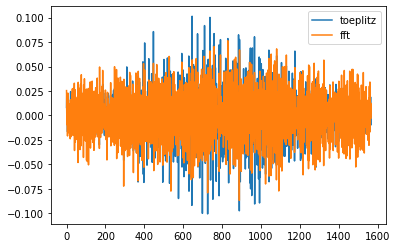

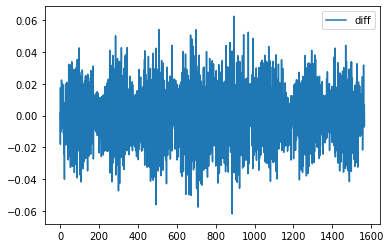

torch.Size([1567])


/home/dekape/miniconda3/lib/python3.7/site-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


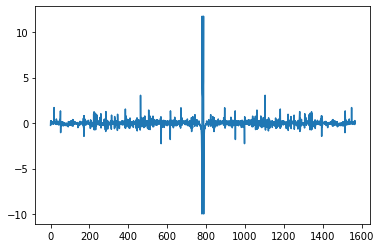

In [5]:
plt.plot(vfilter, label="toeplitz")
plt.plot(wfilter, label="fft")
plt.legend()
plt.show()

diff = wfilter-vfilter
plt.plot(diff, label="diff")
plt.legend()
plt.show()

print(diff.shape)
plt.plot(torch.fft.fft(diff))
plt.show()

Filter size:  torch.Size([55, 55])


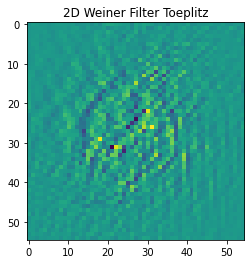

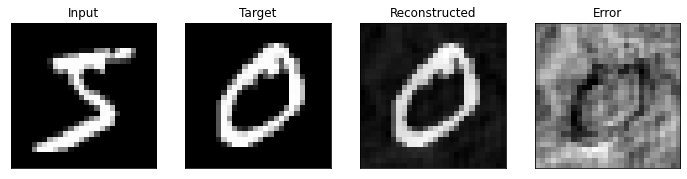

In [5]:
# 2D Weiner Filter using Toeplitz matrix
aw2d = AWLoss2D(epsilon=3e-15, store_filters=True)
_ = aw2d(target, input)
vfilter = aw2d.v_all[0]
print("Filter size: ", vfilter.shape)
plt.imshow(vfilter)
plt.title("2D Weiner Filter Toeplitz")
plt.show()


def get_middle_arr2d(img, shape):
    x_len, y_len = shape[0], shape[1]
    x_start = int(img.shape[0]/2) - int(x_len/2)
    y_start = int(img.shape[1]/2) - int(y_len/2)
    return img[x_start:x_start+x_len, y_start:y_start+y_len]

# Input convolved with filter (reconstructed target)
# recon = signal.convolve2d(torch.flip(input, dims=(0,1)).squeeze(0).squeeze(0), vfilter)
recon = signal.convolve2d(input.squeeze(0).squeeze(0), vfilter)
recon = get_middle_arr2d(recon, (h,w))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

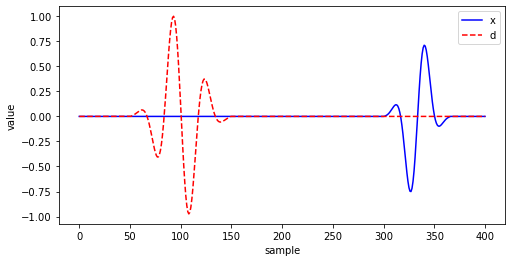

torch.Size([1, 1, 401]) torch.Size([1, 1, 401])


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import torch

def tone_burst(dt, centre_freq, n_cycles, n_samples, envelope='gaussian', offset=0, phase=lambda x:0):
    tone_length = n_cycles/centre_freq
    time_array, step = np.linspace(0, tone_length, int(tone_length/dt+1), retstep=True, endpoint=False)
    tone_burst = np.sin(2*np.pi*centre_freq*time_array+2*np.pi*centre_freq*phase(time_array))
    n_tone = tone_burst.shape[0]
    if envelope=='gaussian':
        limit = 3
        window_x = np.linspace(-limit, limit, n_tone)
        window = np.exp(-window_x**2/2)
    elif envelope=='rectangular':
        window = np.ones((tone_burst.shape[0],))
    else:
        raise Exception('Envelope type not implemented')
    tone_burst = np.multiply(tone_burst, window)
    window = get_window(('tukey', 0.05), n_tone, False)
    tone_burst = np.multiply(tone_burst, window)
    signal = np.pad(tone_burst, ((offset, n_samples-offset-n_tone),), mode='constant', constant_values=0)
    return signal

def signal_plot(x, d, xname='x', dname='d'):
    plt.figure(figsize=(8,4))
    plt.plot(x, label=xname, color='blue')
    plt.plot(d, linestyle='--', label=dname, color='red')
    plt.legend()
    plt.xlabel('sample')
    plt.ylabel('value')
    plt.show()

def complex_plot(x):
    plt.figure(figsize=(5,5))
    plt.plot(x.real, x.imag, color='blue', zorder=1)
    plt.scatter(x.real, x.imag, color='red', edgecolors='black', zorder=2)
    plt.xlabel('real')
    plt.ylabel('imaginary')
    plt.show()
    
def wiener_config(d, scale_factor=2):
    """
    Wiener filter configuration function that calculates the appropriate
    padding required for the specified size of the Wiener filter
    """
    N = len(d)              # length of vector
    P = scale_factor*N      # length of Wiener filter and number of columns in D
    M = N+P-1               # defines number of rows in D matrix
    if (M-N)%2 != 0:        
        P = P+1
        M = N+P-1
    x_pad_val = int((M-N)/2)    # amount of padding for x
    d_pad_val = int(M-N)        # amount of padding for d
    return N, P, M, x_pad_val, d_pad_val

def wienerfft(x, y, prwh=3e-5):
    """
    calculates the optimal least squares convolutional Wiener filter that 
    transforms signal x into signal y
    """
    assert len(x.squeeze()) == len(y.squeeze()), "signals x and y must be the same length"
    Fccorr = torch.fft.fft(torch.flip(x, (0,1)))*torch.fft.fft(y) # cross-correlation of x with y 
    Facorr = torch.fft.fft(torch.flip(x, (0,1)))*torch.fft.fft(x) # auto-correlation of x
    Fdconv = Fccorr/(Facorr+torch.abs(Facorr).max()*prwh) # deconvolution of Fccorr by Facorr
    return torch.fft.irfft(Fdconv, len(x.squeeze())) # inverse Fourier transform

x = np.asarray(10*tone_burst(1e-7, 3e5, 2, 401, offset=300),
                    dtype=np.float32)

d = np.asarray(10*tone_burst(1e-7, 3e5, 3, 401, offset=50),
                    dtype=np.float32)

x, d = x*0.75/np.max(np.abs(x)) , d/np.max(np.abs(d))

signal_plot(x, d)

target = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)
input = torch.from_numpy(d).unsqueeze(0).unsqueeze(0)
print(target.shape, input.shape)

Filter size:  801


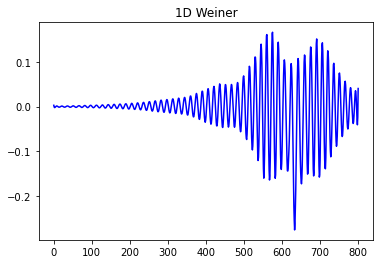

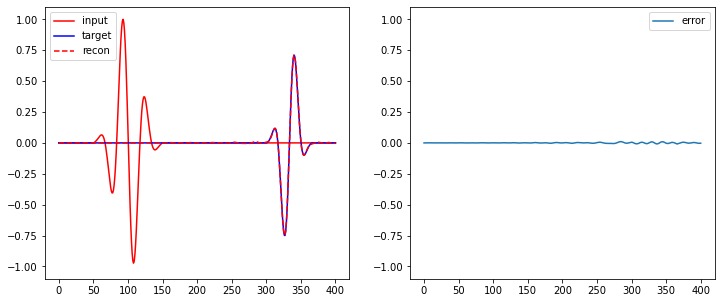

In [7]:
# 1D Weiner Filter using Toeplits
aw1d = AWLoss1D(epsilon=3e-5, store_filters=True)
_ = aw1d(target, input)
vfilter = aw1d.v_all[0]
print("Filter size: ", len(vfilter))
plt.plot(vfilter, color="blue")
plt.title("1D Weiner")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), vfilter, mode="full")
recon = get_middle_arr(recon, len(input.flatten()))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(input.squeeze(0).squeeze(0), label="input", color="red")
ax[0].plot(target.squeeze(0).squeeze(0), label="target", color="blue")
ax[0].plot(recon, label="recon", color="red", linestyle="--")
ax[1].plot(diff, label="error")

for i in ax:
    i.legend()
    i.set_ylim(-1.1, 1.1)
plt.show()

Filter size:  801


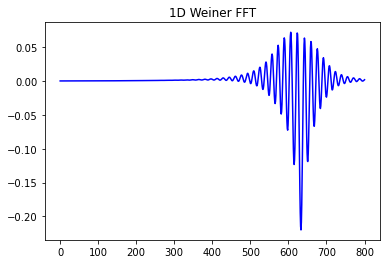

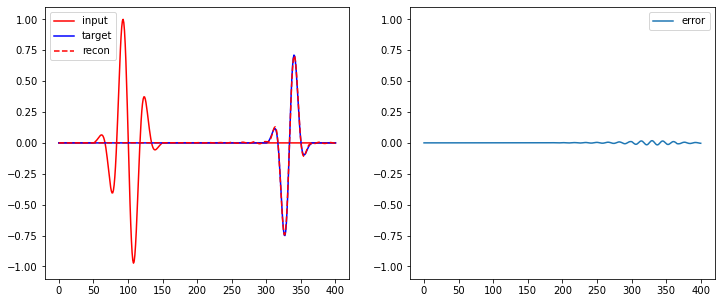

In [8]:
# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=3e-5, store_filters=True)
_ = aw1dfft(input, target)
wfilter = aw1dfft.v_all[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, len(input.flatten()))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(input.squeeze(0).squeeze(0), label="input", color="red")
ax[0].plot(target.squeeze(0).squeeze(0), label="target", color="blue")
ax[0].plot(recon, label="recon", color="red", linestyle="--")
ax[1].plot(diff, label="error")

for i in ax:
    i.legend()
    i.set_ylim(-1.1, 1.1)
plt.show()

(401,) (401,)
torch.Size([1, 1203]) torch.Size([1, 1203])


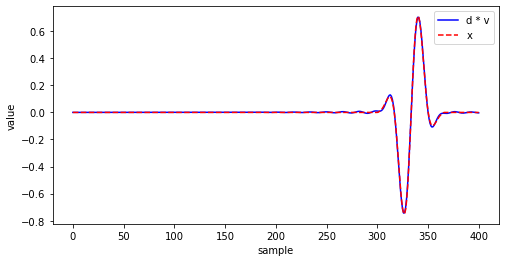

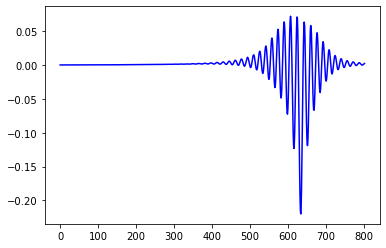

In [9]:
N, P, M, x_pad_val, d_pad_val = wiener_config(d, 2)

x_pad = torch.from_numpy(np.pad(x, (x_pad_val, x_pad_val)))[None]

d_pad = torch.from_numpy(np.pad(d, (0,d_pad_val)))[None]


print(d.shape, x.shape)
print(d_pad.shape, x_pad.shape)
v_FD = wienerfft(d_pad, x_pad)[:,:-(M-P)]


signal_plot(np.convolve(d, v_FD.squeeze())[x_pad_val:x_pad_val+N], x, 'd * v', 'x')

plt.plot(v_FD.squeeze(), color='blue')
plt.show()

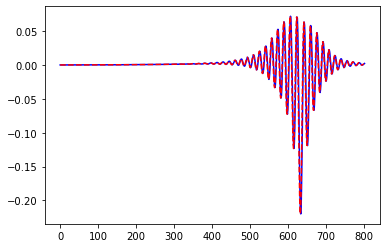

tensor(633)
tensor(634)


In [10]:

plt.plot(v_FD.squeeze(), color='blue')
plt.plot(aw1dfft.v_all[0], "--", color="red")
# plt.plot(aw1d.v_all[0], "--", color="green")
plt.show()

print(torch.argmin(aw1dfft.v_all[0]))
print(torch.argmin(v_FD))


Filter size:  801


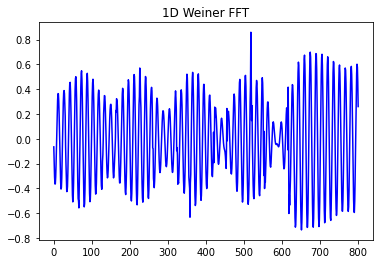

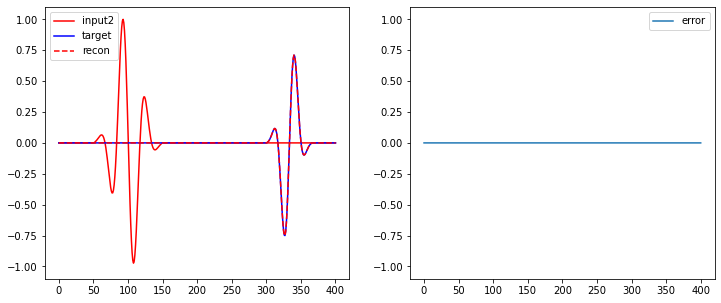

In [12]:
# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=3e-15, store_filters=True)
input2 = input.repeat((2, 1, 1, 1))
input2[1] = -2*input2[1]
_ = aw1dfft(input2, target.repeat((2, 1, 1, 1)))
wfilter = aw1dfft.v_all[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input2[0].flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, len(input2[0].flatten()))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(input2[0].squeeze(0).squeeze(0), label="input2", color="red")
ax[0].plot(target[0].squeeze(0).squeeze(0), label="target", color="blue")
ax[0].plot(recon, label="recon", color="red", linestyle="--")
ax[1].plot(diff, label="error")

for i in ax:
    i.legend()
    i.set_ylim(-1.1, 1.1)
plt.show()